*Disclaimer: this is not an offical Digital Earth Africa notebook*

# Coastal Inundation Tool

* **Products used:**
[strm 1 second elevation model](https://explorer.digitalearth.africa/products/srtm), 

> **Note:** This notebook is one of a companion piece and focuses on coastal inundation as a result of storm surges. The other is titled [River and Urban Flooding]() and focuses on flooding of inland urban areas.

### Background

Coastal Inundation can be defined as the flooding of dry or low-lying land by seawater. It occurs when seawaters breach the topography of coastal areas and penetrate inland. 

Although coastal flooding is largely a natural event its destructive consequences have been increasing. This phenomenon is being fueled by both an increase in population rates and more frequent extreme weather events caused by anthropogenic climate change. Coastal Inundation affects 50% of the global population which live along the coastal zone. Lives, homes, infrustracture and business are all at risk of coastal inundation with massive Social and Economic costs. Flooding of coastal areas also destroys habitats rich in diversity. Biodiversity and habitat loss including salt water intrusion affecting agricultural land and fresh water supply are further Environmental, Social and Economic impacts. Flooding is not directly addressed in the [*Sustainable Development Goals*](https://www.un.org/sustainabledevelopment/sustainable-development-goals/) but it is significant to achieving [No Poverty (goal 1)](https://www.un.org/sustainabledevelopment/poverty/), Ensuring [Good Health and Wellbeing for All (goal 3)](https://www.un.org/sustainabledevelopment/health/), [Clean Water and Sanitation (goal 6)](https://www.un.org/sustainabledevelopment/water-and-sanitation/), [Sustainable Cities and Communities (goal 11)](https://www.un.org/sustainabledevelopment/cities/) and [Life on Land (goal 15)](https://www.un.org/sustainabledevelopment/biodiversity/). *([a recent paper highlights how flooding relates to the Sustainable Development Goals within Nigeria](https://www.tandfonline.com/doi/full/10.1080/20964129.2020.1791735))*

The `Coastal Inundation Tool (CiT)` is different from empirical methods and hydrodynamic models which are widely applied in flood inundation modelling. The `CiT` provides at a glance insights into coastal dynamics. The `CiT` is a summary that investigates the [srtm elevation dataset](https://explorer.digitalearth.africa/products/srtm)  held within Digital Earth Africa (DE Africa). `Elevation` data is retrieved from DE Africa and extracted to produce a water mask describing the possible flooding during storm surge events through an inundation polygon.  

<!-- > `Detailed Explanation:`-->
<!--Data ... time.-->

### Description
This notebook will run the Coastal Inundation Tool for an area of interest. We extract elevation profiles related to inundation senarios. And overlay flood masks to visualize the potential impact.


1.  Load in the srtm
2.  Extract Area of Interest
3.  Run the Coastal Inundation Tool
4.  Plot the results
5.  Overlay and visualize the result.
6.  Export inundation polygons (masks).

<!-- 6.  Validate  -->
<!-- 7.  Generate a second animation comparing the per-pixel classification to the true colour timeseries -->
***

> **Note: This notebook goes further and validates an actual event. Tropical Cyclone Idai made landfall near Beira city, Mozambique on 15 March 2019 with devastaing consequences. Unfortunately due to the nature of the event DE Africa ARD cannot penetrate the clouds following such weather. To test the effectiveness of this tool [Sentinel 1 Synthetic Aperture Radar (SAR)](https://sentinel.esa.int/web/sentinel/sentinel-data-access) was sourced and processed to compare predicted with actual data.**

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the *"Analysis parameters"* cell, modify some values (e.g. choose a different area of interest) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

***

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

from osgeo import gdal

sys.path.append('../Scripts')
from deafrica_spatialtools import xr_vectorize
from deafrica_plotting import display_map, rgb
from datacube.utils.cog import write_cog
from deafrica_datahandling import load_ard
#from deafrica_dask import create_local_dask_cluster

#This will speed up loading data
#datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app='Coastal_Inundation_Tool')

### Analysis parameters 

The following cell sets important parameters for the analysis:

- lat: The central longitude to analyse (e.g. 34.70).
- lon: The central latitude to analyse (e.g. -19.85).
- buffer: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower.

**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results. The example generates inundation polygons (masks) for an area near Beira city, Mozambique.

In [3]:
# Define the central point of the area of interest
lat, lon = -19.85, 34.70

# buffer will define the upper and lower boundary from the central point
buffer = 0.1   

# Combine central lat, lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

### View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point

In [4]:
display_map(x=(lon - buffer, lon + buffer), y=(lat + buffer, lat - buffer))

## Load elevation data

To evaluate Coastal Inundation, we first need to obtain an elevation dataset. DE Africa's datacube contains a Digital Elevation Model (DEM) from the [Shuttle Radar Topography Mission (SRTM)](https://lpdaac.usgs.gov/documents/13/SRTM_Quick_Guide.pdf). We can load in elevation data directly from the datacube using `dc.load`.

The Shuttle Radar Topography Mission NASA JPL Version 3.0 *(“SRTM Plus”)* is void filled with non-commercial ASTER GDEM2, GMTED2010, and NED, to produce a 1 arc-second (~30m) product.

**NOTE: This elevation dataset is not hydrologically correct and is not meant for hydraulic analysis but it can serve as a guide to inform further investigation.**

In [5]:
# Create a dem reusable query
dem_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'resolution': (-30, 30)
}

#load elevation
elevation_array = dc.load(product ='srtm', **dem_query)
elevation_array

<xarray.Dataset>
Dimensions:      (time: 1, x: 706, y: 746)
Coordinates:
  * time         (time) datetime64[ns] 2019-09-09
  * y            (y) float64 7.816e+06 7.816e+06 ... 7.793e+06 7.793e+06
  * x            (x) float64 6.675e+05 6.675e+05 ... 6.886e+05 6.886e+05
    spatial_ref  int32 2736
Data variables:
    elevation    (time, y, x) int16 8 8 8 7 5 5 4 4 4 6 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:2736
    grid_mapping:  spatial_ref

Once the load is complete, the last `elevation_array` parameter printed it. The returned Dataset has a single entry in the time dimension. To make the data easier to work with, we convert it to a dataArray.

In [6]:
#convert to an dataArray (rather an Dataset) and select single time-slice
dem = elevation_array[['elevation']].isel(time=0).to_array()

### Plot the loaded data

We can plot the elevation data for the region using a custom colour map:

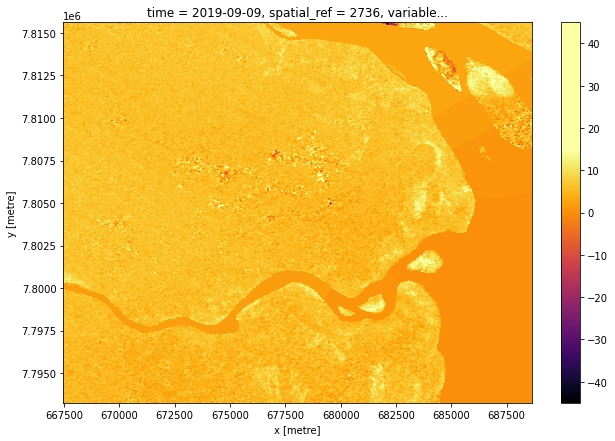

In [7]:
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.inferno(np.linspace(0.0, 1.5, 25))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('inferno', colors_terrain)

# Plot a subset of the elevation data
dem.plot(size=7, cmap=cmap_terrain)
plt.show()

### Histogram

An extremely effective method of exploring the distribution of elevation values is a histogram.

> **Note**:  
> We extend the basic `matplotlib` `.hist` function and apply our previously generated `colormap`. This way the histogram *(the distribution)* matches the plot above.

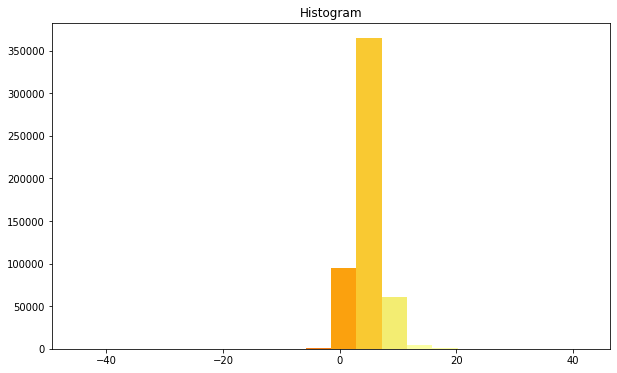

In [12]:
# Plot a histogram
f, ax = plt.subplots(figsize=(10, 6))

# Plot histogram.
n, bins, patches = dem.squeeze().plot.hist(ax=ax,
                                           color="purple",
                                           bins=20)                 # 20 bins might be a bit much for coastal arears
bin_centers = 0.8 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap_terrain(c))

plt.show()

The histogram above represents the distibution of elevation values in our data. It provides a shapshot of our area of interest and is usefull because: 

   * We can easily identify outliers;  
   * Quickly determine the `min` and `max` values;  
   * Explore the general distribution values of the data and draw conclusions *(is the area hilly? or flat? is the area low-lying or high-lying?)*.

## Extract multiple inundation senarios

Although many methods and hydrodynamic models exist to simulate inundation this tool uses the least complex. `CiT` mimics the popular [Flood Fill](https://en.wikipedia.org/wiki/Flood_fill) image processing technique. Flood Fill determines the area connected to a given node in a multiple dimension array and is used in the *bucket* tool of paint programs to fill connected, similarly-colored areas with a different color, and in games such as **Go** and **Minesweeper** for determining which pieces are cleared. This tool thus assumes that surge water will flow to areas of the same elevation. 

We extract possible flooding senarios at 0 to 6 meters.

> `python` counts from zero. To extract elevations from 0 to six meters we set a range of seven.

In [20]:
flood_range = 7

Then place each elevation in a dictionary.

In [21]:
mask = {}

for k in range(flood_range):
    mask[k] = elevation_array.elevation <= k

### Plot each possible water level

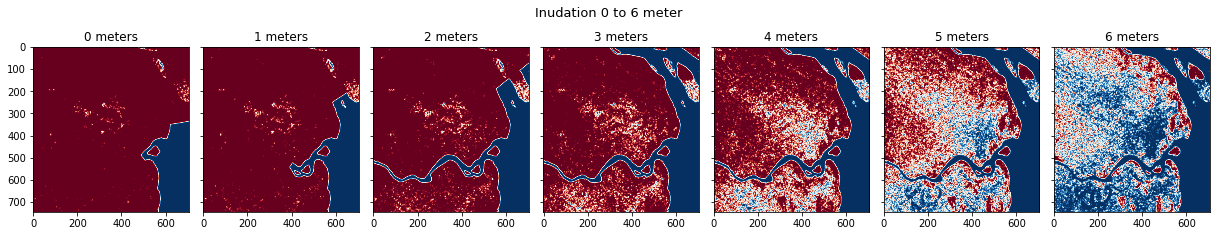

In [22]:
_, axs = plt.subplots(1, len(mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(mask, axs):
    ax.imshow(mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')
    
plt.suptitle('Inudation 0 to 6 meter', size = 13, y = 0.6)
plt.tight_layout()
plt.show()

### Vectorize each elevation mask to a geodataframe

In the cell below, we use the argument `mask=mask[i].values==1` to indicate we only want to convert the values in the xarray object that are equal to 1. We also add a `vectorize_gdf['z_value'] = i` parameter to add an elevation attribute to each polygon.

> Note: Both `xr_rasterize` and `xr_vectorize` will attempt to automatically obtain the `crs` and `transform` from the input data, but if the data does not contain this information, you will need to manually provide this. In the cell below, we will harvest the `crs` and `transform` from the original dataset.


In [20]:
gdf = gpd.GeoDataFrame()

for i in mask:
        vectorize_gdf = xr_vectorize(mask[i],
                                     crs=elevation_array.crs,
                                     transform=elevation_array.geobox.transform,
                                     mask=mask[i].values==1)
        vectorize_gdf['z_value'] = i
        gdf = gdf.append(vectorize_gdf, ignore_index=True)

This returns a `geopandas.GeoDataFrame` containing each flooding senario with the elevation given in a field named `z_value`. 

> We can query the `.unique` elevation (`z_values`) values

In [21]:
gdf.z_value.unique()

array([0, 1, 2, 3, 4, 5, 6])

> And we can query the `.head`  and `.tail` of the `GeoDataFrame`

In [22]:
gdf.tail(5)

,attribute,geometry,z_value
17892,1.0,"POLYGON ((678210.000 7793280.000, 678210.000 7...",6
17893,1.0,"POLYGON ((681750.000 7793280.000, 681750.000 7...",6
17894,1.0,"POLYGON ((681930.000 7793310.000, 681930.000 7...",6
17895,1.0,"POLYGON ((667890.000 7815630.000, 667890.000 7...",6
17896,1.0,"POLYGON ((683430.000 7793280.000, 683430.000 7...",6


### Plot a selected water level over the DEM

Select an elevation between 0 and 6 meters

In [23]:
test = 4

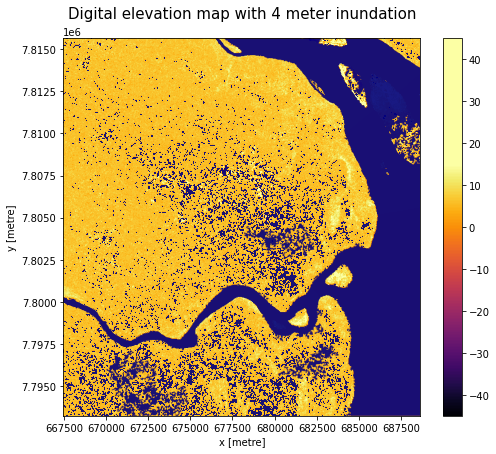

In [37]:
assert test >= 0 and test <= 7, "Values must be between 0 and 6."
    
# Plot a subset of the elevation data
fig, ax = plt.subplots(figsize=(8,6))
#fig.patch.set_alpha(0)

dem.plot(cmap=cmap_terrain, zorder=1)
gdf_plot = gdf[gdf['z_value'] == test]
gdf_plot.plot(ax=ax, zorder=2, color='navy', linewidth=0.5, alpha=0.9)
ax.set_title('Digital Elevation Map with ' +str(test)+ ' meter inundation', pad=20, fontsize=15)
plt.subplots_adjust(top=1)
plt.show()

### Exporting Coastal Inundation to file

The GeoDataFrame natively exports as a shapefile for use in other applications.

> Exporting to GeoJSON is supported through adding the `driver=` parameter.  
    `gdf.to_file("CoastalInundation.geojson", driver='GeoJSON')`

In [62]:
gdf.to_file("../Supplementary_data/WorkingFolder/CoastalInundation.shp")

## 3D Surface Visualization

We can create a dynamic visualization showing possible flooding over a 3D surface.

> **NOTE**: `mpl_toolkits.mplot3d` `Axes3D` the module used to represent the DEM as a 3D surface is computationally expensive. Even with the region `buffer` set to 0.1 degrees rendering the plot will some time. 


<div class="alert alert-block alert-warning">
    
<b>ATTENTION:</b>
    
- **HERE A 3D SURFACE PLOT WOULD BE IMPRESSIVE BUT THE SRTM IS PROVING CHALLENGING TO RENDER CORRECTLY. AFTER EXTRACTING THE x, y and z DIMENSIONS FROM THE DEM; IS RE-INTERPOLATION (nearest/cubic) NECESSARY? THE PLOT LOOKS TERRIBLY NOISY.**
    
- **HOW TO GO DIRECTLY TO A 3D SURFACE WITHOUT GOING THROUGH GDAL?** *(I might have solved this but the surface is still terribly noisy)*
    
- **HOW TO *'HARD CODE'* AND VISUALIZE ONLY A FRACTION OF THE TOTAL ANALYSIS AREA? [so that the analysis area can increase in size but exploratory visualization is less computationally expensive].**
    
- **OVERLAYING THE DEM WITH THE FLOOD LEVEL IS ALSO PROVING CHALLENGING. HELP WOULD BE APPRECIATED.**
</div>

In [63]:
# Write GeoTIFF
write_cog(geo_im = dem,
          fname = '../Supplementary_data/WorkingFolder/smallBeira_dem.tif',
          overwrite=True)

PosixPath('../Supplementary_data/WorkingFolder/smallBeira_dem.tif')

In [12]:
#read tiff
tiff = gdal.Open('../Supplementary_data/WorkingFolder/smallBeira_dem.tif')

#get image metrics
dem_bnd = tiff.GetRasterBand(1)
gt  = tiff.GetGeoTransform()
dem_image = dem_bnd.ReadAsArray()
no_data = dem_bnd.GetNoDataValue()

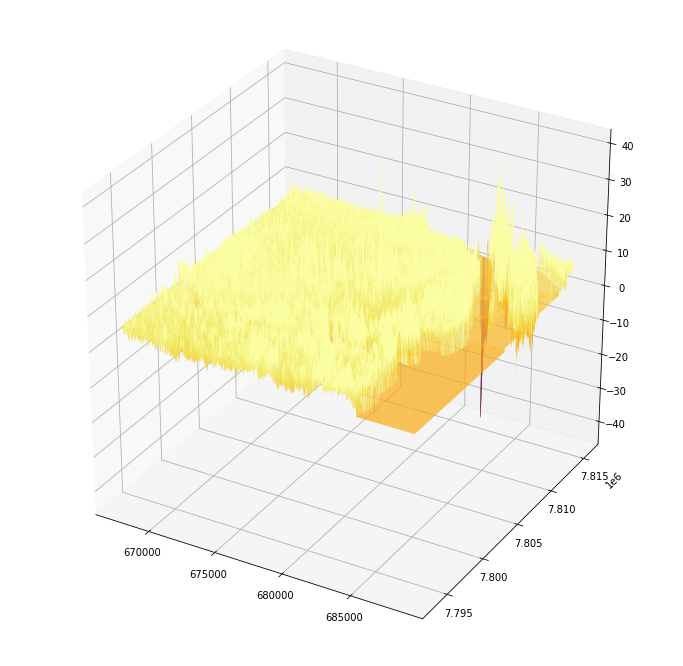

In [39]:
# set up a figure 
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

#transform the image
xres = gt[1]
yres = gt[5]
X = np.arange(gt[0], gt[0] + dem_image.shape[1]*xres, xres)
Y = np.arange(gt[3], gt[3] + dem_image.shape[0]*yres, yres)
X, Y = np.meshgrid(X, Y)

# plot a 3D surface --- oriented North West from the bottom right corner
surf = ax.plot_surface(X,Y,dem_image, rstride=2, cstride=2, cmap=cmap_terrain, linewidth=0, antialiased=True, zorder=2)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)

plt.show()

<div class="alert alert-block alert-danger">
<b>NOTE:
        
</b> **BELOW IS THE ATTEMPT TO GO DIRECTLY TO `matplotlib` WITHOUT GOING THROUGH `gdal`.**</div>

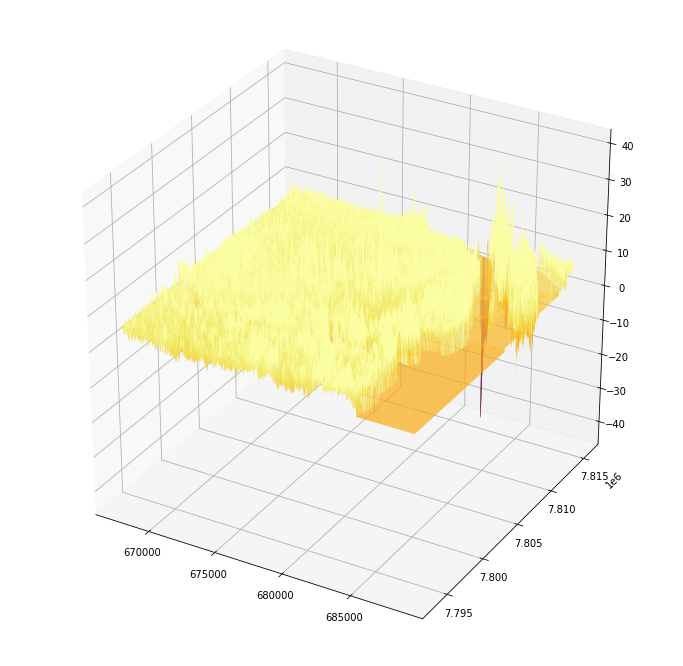

In [19]:
# set up a figure 
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

#transform the image
xres = elevation_array.geobox.transform[0]
yres = elevation_array.geobox.transform[4]
X = np.arange(elevation_array.geobox.transform[2], elevation_array.geobox.transform[2] + dem.shape[1:][1]*xres, xres)
Y = np.arange(elevation_array.geobox.transform[5], elevation_array.geobox.transform[5] + dem.shape[1:][0]*yres, yres)
X, Y = np.meshgrid(X, Y)

# plot a 3D surface --- oriented North West from the bottom right corner
surf = ax.plot_surface(X,Y,dem.squeeze(), rstride=2, cstride=2, cmap=cmap_terrain, linewidth=0, antialiased=True, zorder=2)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)

plt.show()

## Validation

In order to test the effectiveness of our tool we can compare an actual event with our prediction.

> On 15 March 2019 Cyclone Idai made landfall near Beira, Mozambique. The neighbouring nations of Madagascar, Malawi and Zimbabwe all suffered the storms destructive power. A total 3 million people were affected by the winds, rain and flooding that followed the storms path. Of particular concern were the outbreak of water bourne diseases, such as cholera, in flooded areas. Incidence of malaria caused by malarial mosquitoes breeding in stagnant flood water also increased.  Reports estimates the total cost of destruction between `$2bn` and `$1bn`. ([Wikipedia, 2020](https://en.wikipedia.org/wiki/Cyclone_Idai#Disease_outbreaks))

Optical datasets, such as [Sentinel 2](https://explorer.digitalearth.africa/products/s2_l2a) available within DE Africa, cannot penetrate the cloud-cover following an event of this nature.

We can execute a query and check.

In [99]:
# Define the start and end dates that define the search
start_year = '2019-03-11'
end_year = '2019-03-30'

#Create a query object
sen_query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'resolution': (-10, 10),
    'output_crs':'EPSG:2736',
    'group_by': 'solar_day',
    'time': (start_year, end_year)
    #'dask_chunks':{'time':1,'x':1000,'y':1000}
}

In [100]:
ds_sen2 = load_ard(dc=dc,
                      products=['s2_l2a'],
                      measurements=['red', 'green', 'blue', 'nir'],
                      #min_gooddata = 0.10,
                      **sen_query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 4 time steps as a dask array


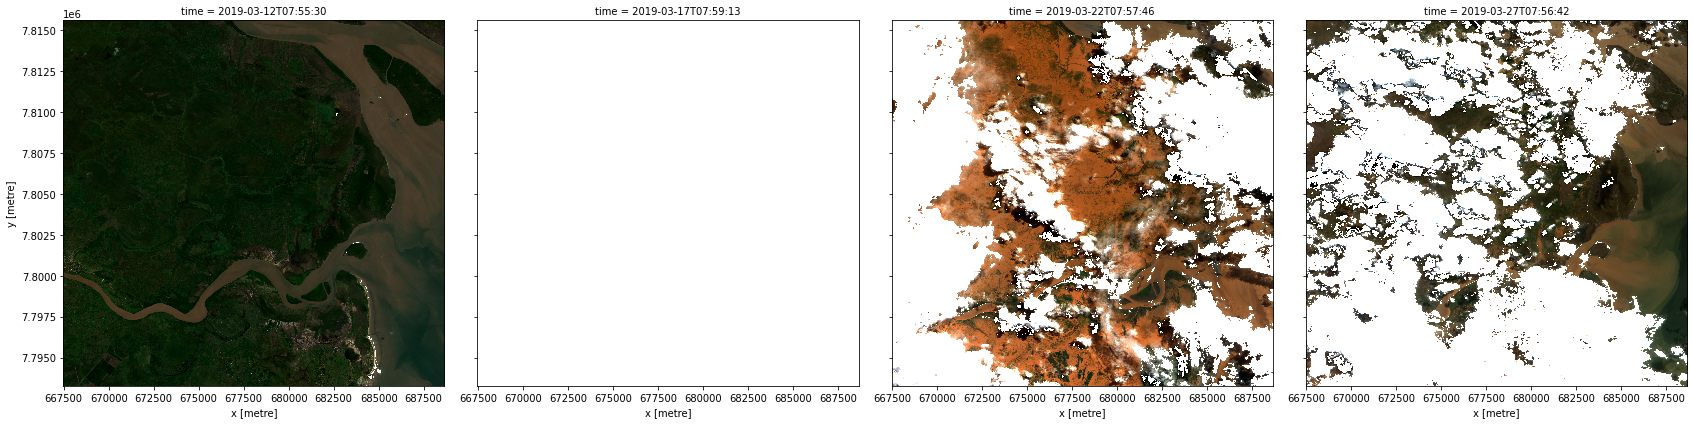

In [101]:
rgb(ds_sen2, col='time', col_wrap = 5)

Cloud cover prevents a certain evaluation after Idia's landfall (15 March).

### Sentinel-1

> Radar observations are largely unaffected by cloud cover, so can take reliable measurements of areas in any weather. Radar data is readily available from the ESA/EC Copernicus program's Sentinel-1 satellites. The two satellites provide all-weather observations, with a revisit time of 6 days. By developing a process to classify the observed pixels as either water or land, it is possible to identify the water from radar data. For more information, see the [Detecting water with radar](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Real_world_examples/Radar_water_detection.ipynb) and [Sentinel-1](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/03b7b41d5f6526ff3f33618f7a0b48c0d10a155f/Datasets/Sentinel_1.ipynb)  notebooks.

> Unfortunately DE Africa does not have the data we need. Fortunately Google Earth Engine does.

<div class="alert alert-block alert-info"><b>
    
    
NOTE:</b> **HEREAFTER THE VALIDATION WITH SAR IS PERFORMED.**
</div>

In [ ]:
from shapely.geometry import Polygon
from shapely.geometry import box

## Google Earth Engine

[Google Earth Engine (GEE)](https://developers.google.com/earth-engine) serves as the perfect complement to DE Africa. It is a planetary scale platform for Earth Science data and analysis with a peta-byte catalog of satellite imagery and geospatial dataset. Access to Earth Engine services is through one of three Application Protocol Interface's (API's). Client libraries for [JavaScipt (in the Code Editor)](https://developers.google.com/earth-engine/guides/playground) and [Python (in Colab)](https://developers.google.com/earth-engine/guides/python_install) or directly using REST API.

### Define the extents of the area of interest and export to .shp

To make our work less error prone we use the extents of our area of interest to define a boundary box which we convert to a shapefile. This boundary is imported to Google Earth Engine to limit our search area and serve as a basis to then extract the data (water coverage) we need.

In [26]:
minx = elevation_array.geobox.transform[2]
maxy = elevation_array.geobox.transform[5]
maxx = minx + elevation_array.geobox.transform[0] * dem.shape[1:][0]
miny = maxy + elevation_array.geobox.transform[4] * dem.shape[1:][1]

coordinates = [minx, miny, maxx, maxy]
print(coordinates)

[667470.0, 7794450.0, 689850.0, 7815630.0]


In [64]:
bbox = gpd.GeoDataFrame({"id":1,"geometry":[box(*coordinates)]})
bbox = bbox.set_crs("EPSG:2736")

In [70]:
bbox.head()

,id,geometry
0,1,"POLYGON ((688650.000 7793250.000, 688650.000 7..."


### Export

In [71]:
bbox.to_file("../Supplementary_data/WorkingFolder/bbox.shp")

### GEE Code Editor

The script to execute the water identification from SAR imagery is available [here](https://code.earthengine.google.com/a68ec71d723fb202e40674ef65bc6ca5). A GEE account might be necessary.

<div class="alert alert-block alert-success">  
    
<b>NOTE: </b>**IT WILL BE HELPFUL TO TEST THE EFFECTIVENESS OF THE LINK AND SCRIPT. IS THERE ANOTHER / BETTER METHOD TO SHARE IT?**</div>

> NOTES:
> - The Area of Interest (`aoi`) is the `.shp` exported in the previous `cell`. It must be imported as an `Asset` or manually drawn.
> - Water classification is based on the Otsu method [(Otsu, 1979)](https://ieeexplore.ieee.org/document/4310076/authors#authors). It is an automated image classification method of finding an optimal threshold based on the observed distribution of pixel values. 
> - Uncommment lines 74 through 80 to export the classification which when the script is `Run` will highlight as a `Task`.
> - Export of the water extent as a vector is also catered for and similarly needs to be uncommented. 

## Import the SAR water classification

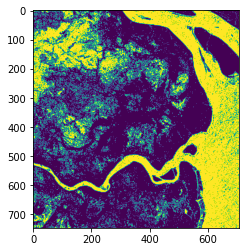

In [23]:
dataset = gdal.Open('../Supplementary_data/WorkingFolder/Beira_19032019_flooding.tif')#, gdal.GA_ReadOnly) 

# Note GetRasterBand() takes band no. starting from 1 not 0
#band = dataset.GetRasterBand(1)
arr = dataset.ReadAsArray()

#plt.imshow(arr)

### Compare the actual Inundation with the predictions

In [14]:
import matplotlib.gridspec as gridspec

NameError: name 'mask' is not defined

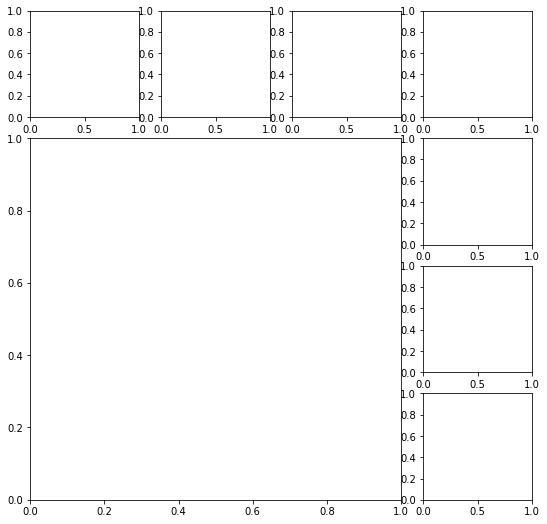

In [15]:

fig = plt.figure(figsize=(9, 9), constrained_layout=False)
a1 = plt.subplot2grid((4,4),(0,0))
a2 = plt.subplot2grid((4,4),(0,1))
a3 = plt.subplot2grid((4,4),(0,2))
a4 = plt.subplot2grid((4,4),(0,3))

a5 = plt.subplot2grid((4,4),(1,0), rowspan = 3, colspan = 3)

a6 = plt.subplot2grid((4,4),(1,3))
a7 = plt.subplot2grid((4,4),(2,3))
a8= plt.subplot2grid((4,4),(3,3))

a1.imshow(mask[0].squeeze())
a1.set_title('0 meters')
a2.imshow(mask[1].squeeze())
a2.set_title('1 meters')
a3.imshow(mask[2].squeeze())
a3.set_title('2 meters')
a4.imshow(mask[3].squeeze())
a4.set_title('3 meters')
a5.imshow(arr) #a1.set_title('exp')
a5.set_title('SAR water extent: 19 March 2019')
a6.imshow(mask[4].squeeze())
a6.set_title('4 meters')
a7.imshow(mask[5].squeeze())
a7.set_title('5 meters')
a8.imshow(mask[6].squeeze())
a8.set_title('6 meters')

#plt.axes.xaxis.set_ticks([])
#plt.axes.yaxis.set_ticks([])
#plt.tick_labels('off')
plt.tight_layout()
plt.show()

## Drawing conclusions

Here are some questions to think about:
* What can you conclude about the actual level of Inundation? 
* Which sections of the coastal area are likely to be most affected? 
* Is the prediction realistic? How can the prediction be improved?
* What other information might you need to draw additional conclusions about potential problem areas?

## Next steps
When you are done, return to the "Analysis parameters" cell, modify some values (e.g. `lat`/`lon`) and rerun the analysis.

Consider increasing the `buffer` and exploring a larger area without the *computationally expensive* 3D Visualization. 